## Prepare TADPOLE data

In [8]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

import seaborn as sns

In [2]:
path = '/network/lustre/dtlake01/aramis/datasets/adni/leaspy/raw/TADPOLE_2019_12_10/tadpole_challenge/'

In [29]:
columns = ['RID', 'AGE', 'Month', 'Hippocampus', 'Ventricles', 'ADAS13', 'ICV']
D1 = pd.read_csv(path+'TADPOLE_D1_D2.csv', usecols = columns)
D1['TIME'] = D1['AGE'] + D1['Month']/12
D1 = D1.rename(columns={'RID':'ID'})
D1 = D1.set_index(['ID', 'TIME'])
D1 = D1[~D1.index.duplicated(keep='first')]

D1

AGE  ADAS13  Ventricles  Hippocampus        ICV  Month
ID   TIME                                                         
2    74.3  74.3   18.67    118233.0       8336.0  1984660.0      0
3    81.3  81.3   31.00     84599.0       5319.0  1920690.0      0
     81.8  81.3   30.00     88580.0       5446.0  1906430.0      6
     82.3  81.3   35.00     90099.0       5157.0  1903820.0     12
     83.3  81.3   37.67     97420.0       5139.0  1903420.0     24
...         ...     ...         ...          ...        ...    ...
4167 74.5  69.5     NaN         NaN          NaN        NaN     60
4199 64.0  59.0   12.00         NaN          NaN        NaN     60
4557 88.3  83.3   22.00         NaN          NaN        NaN     60
4512 73.0  68.0    7.00         NaN          NaN        NaN     60
2380 73.3  67.8   21.00         NaN          NaN        NaN     66

[12619 rows x 6 columns]

array([[<AxesSubplot:title={'center':'ADAS13'}>,
        <AxesSubplot:title={'center':'Ventricles'}>],
       [<AxesSubplot:title={'center':'Hippocampus'}>, <AxesSubplot:>]],
      dtype=object)

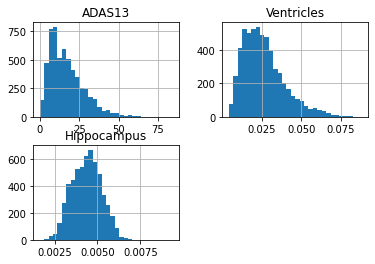

In [30]:
D1['Hippocampus'] = D1['Hippocampus']/D1['ICV']
D1['Ventricles'] = D1['Ventricles']/D1['ICV']
D1 = D1.dropna()
D1 = D1.drop(['ICV', 'AGE', 'Month'], axis=1)
D1.hist(bins=30)

In [31]:
D1['ADAS13'] /= 50
D1['Ventricles'] /= 0.06
D1['Hippocampus'] /= 0.008

for visit in D1.index:
    hip, ven, adas = D1.loc[visit].values
    if (hip > 1) or (ven > 1) or (adas > 1):
        D1 = D1.drop(visit)
        
D1['Hippocampus'] = 1 - D1['Hippocampus']

array([[<AxesSubplot:title={'center':'ADAS13'}>,
        <AxesSubplot:title={'center':'Ventricles'}>],
       [<AxesSubplot:title={'center':'Hippocampus'}>, <AxesSubplot:>]],
      dtype=object)

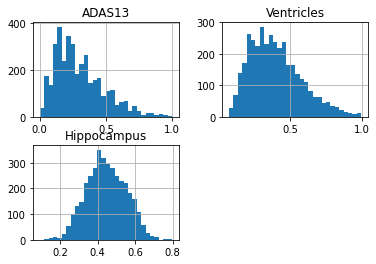

In [34]:
for sub in D1.index.get_level_values(0).unique():
    if len(D1.loc[sub]) < 4:
        D1 = D1.drop(sub, level=0)
        
D1 = D1.sort_index()
D1.hist(bins=30)

In [35]:
D1.describe()

,ADAS13,Ventricles,Hippocampus
count,3739.000000,3739.000000,3739.000000
mean,0.300106,0.402083,0.445945
std,0.184379,0.179359,0.104318
min,0.000000,0.075044,0.091902
25%,0.160000,0.262730,0.372381
50%,0.260000,0.377550,0.441891
75%,0.406600,0.511101,0.523340
max,1.000000,0.998250,0.796335


In [36]:
D1.to_csv('tadpole/data/D1.csv')

In [37]:
X = np.array(D1.index.get_level_values(1))
Y = D1.values
group = np.array(D1.index.get_level_values(0))

In [38]:
data_path = 'tadpole/data/'
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

## Evaluate reconstruction error

In [4]:
path = 'tadpole/'
output_folder = 'output/'

In [5]:
rer = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
       allow_pickle=True)[()]
ids = pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

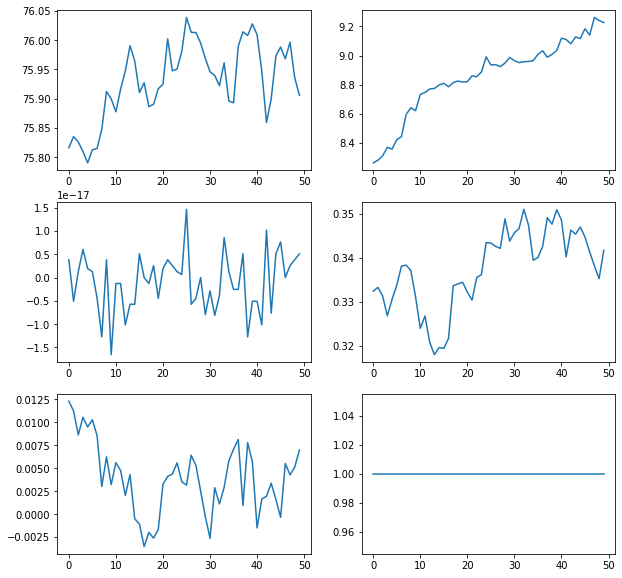

In [10]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

In [62]:
# Then in the required format for the deformetrica model

rer['onset_age'] = rer['onset_age'].mean(axis=0)
rer['log_acceleration'] = rer['log_acceleration'].mean(axis=0)
rer['sources'] = np.array([[source] for source in rer['sources'].mean(axis=0)])
averaged_rer = rer
averaged_rer

{'onset_age': array([ 96.3503807 ,  97.10032507,  69.52103783,  73.69770558,
         87.22543853,  86.16386943,  63.37203183,  55.66059291,
         68.17080044,  76.54366689,  87.60788503,  75.11964902,
         87.2553502 ,  83.61753676,  83.01393245,  81.65975476,
         76.20307935,  71.926339  ,  88.87674247,  65.7231705 ,
         70.45499951,  75.02677022,  76.27626305,  73.91451393,
         83.99924536,  75.84978381,  78.28030567,  72.71630306,
         66.69524911,  81.67219581,  64.09809849,  78.17526053,
         55.48046437,  80.70795929,  75.78284674,  70.93717518,
         84.94650863,  74.20748044,  56.9733308 ,  70.91386157,
         74.33448895,  82.99567144,  72.91201511,  66.57113248,
         61.87296663,  80.53916781,  67.16032144,  87.88383997,
         71.91800216,  81.20091625,  80.48389207,  79.64226808,
         81.98841876,  83.48704876,  81.67902221,  91.88868228,
         84.92402735,  84.96257637,  63.8168009 ,  83.14415816,
         80.08349221,  76.0

In [66]:
# First we put them in a dataframe for visualization purpose

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])
ip['tau'] = rer['onset_age'].mean(axis=0)
ip['xi'] = rer['log_acceleration'].mean(axis=0)
ip['source'] = rer['sources'].mean(axis=1)

ip

ValueError: Length of values (50) does not match length of index (430)

In [11]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])

ip['tau'] = tau
ip['xi'] = xi
ip['source'] = sources

ip

/tmp/ipykernel_2335510/1755275170.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]


,tau,xi,source
3,60.457785,0.121805,0.488642
4,64.141924,-0.118443,0.403011
5,76.631913,-0.205578,-0.027346
6,73.834423,-0.081194,0.397542
10,70.944207,-0.046605,0.886324
...,...,...,...
4989,77.670445,-0.034315,0.359975
5066,76.604543,-0.322377,-0.184773
5079,82.013089,-0.007588,-0.119237
5082,78.902407,-0.143520,-0.529843


In [13]:
path = 'tadpole'
data = '/data'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
adas = [score[0] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ven = [score[1] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
hip = [score[2] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [14]:
data = pd.DataFrame(index=[ids, times], columns=['hip', 'ven', 'adas'])
data['hip'] = hip
data['ven'] = ven
data['adas'] = adas
data.index.set_names(['ID','TIME'], inplace=True)
data

hip       ven    adas
ID   TIME                            
3    81.3  0.538447  0.800839  0.6200
     81.8  0.523892  0.844797  0.6000
     82.3  0.548539  0.860461  0.7000
     83.3  0.550020  0.930574  0.7534
4    67.5  0.318324  0.428768  0.4266
...             ...       ...     ...
5082 71.2  0.174026  0.417257  0.0600
5093 69.3  0.239992  0.254152  0.1000
     69.8  0.233425  0.247965  0.0200
     70.3  0.230711  0.252195  0.0600
     71.3  0.206244  0.263842  0.1200

[3564 rows x 3 columns]

array([[<AxesSubplot:title={'center':'hip'}>,
        <AxesSubplot:title={'center':'ven'}>],
       [<AxesSubplot:title={'center':'adas'}>, <AxesSubplot:>]],
      dtype=object)

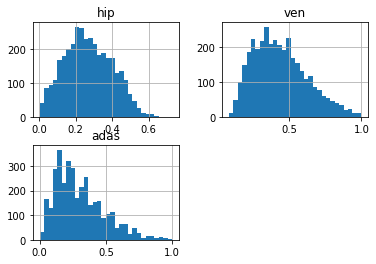

In [15]:
data.hist(bins=30)

In [16]:
reconstructed = pd.read_csv('tadpole/output/LongitudinalMetricModel_reconstructed_values.txt', sep=' ', header=None)
reconstructed.columns = ['adas', 'ven', 'hip']
reconstructed.index = data.index

In [17]:
abs(reconstructed-data).describe()

,adas,hip,ven
count,3564.000000,3564.000000,3564.000000
mean,0.061290,0.055593,0.026778
std,0.052967,0.047029,0.024415
min,0.000052,0.000006,0.000005
25%,0.023831,0.021476,0.009454
50%,0.050380,0.045007,0.020800
75%,0.082948,0.078048,0.037079
max,0.410856,0.403480,0.251033


## 2. Evaluating the reconstruction error

In [21]:
path = 'tadpole'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_tadpole.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [22]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

134 good iterations out of 135
171 good iterations out of 172


In [ ]:
onset_ages = torch.tensor(estimated_parameters['onset_age'])
log_accelerations = torch.tensor(estimated_parameters['log_acceleration'])
sources = torch.tensor([[float(source[1:-1])] for source in estimated_parameters['sources'].values])

In [23]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

134 good iterations out of 135
171 good iterations out of 172


In [24]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])

    targets_i = targets[i].cpu().data.numpy()


In [26]:
predicted = data.copy()
predicted['adas'] = [prediction[0] for prediction in predictions]
predicted['ven'] = [prediction[1] for prediction in predictions]
predicted['hip'] = [prediction[2] for prediction in predictions]

In [27]:
diff = predicted - data
abs(diff).describe()

,hip,ven,adas
count,3564.000000,3564.000000,3564.000000
mean,0.055587,0.026767,0.061344
std,0.047018,0.024451,0.053008
min,0.000033,0.000001,0.000024
25%,0.021490,0.009453,0.023856
50%,0.045016,0.020823,0.050428
75%,0.078063,0.036953,0.083103
max,0.406230,0.252628,0.410942


## Leaspy model

In [90]:
data['ID'], data['TIME'] = data.index.get_level_values(0), data.index.get_level_values(1)
data = data.set_index('ID')
individual_parameters = pd.read_csv('leapsy/tadpole.csv').set_index('ID')
individual_parameters.index = data.index.unique()
individual_parameters

,tau,xi,sources
ID,,,
21,85.623108,0.485074,-0.036556
56,87.378098,0.356685,-0.183288
69,67.445099,-0.305585,0.035441
377,72.936371,0.041512,-0.233056
413,85.360130,-0.119878,0.686009
...,...,...,...
5259,87.225395,-0.013813,-0.684990
5265,75.593620,1.042938,1.086733
5266,77.901566,0.329376,0.933305


## Visualization of tau/alpha correlations with diagnosis

In [ ]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [ ]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


In [ ]:
sub_diag

In [ ]:
%matplotlib inline

sub_diag = sub_diag.loc[ip.index]
ip['diag'] = sub_diag['diag']
ip['label'] = sub_diag['label']

sns.scatterplot(data = ip,
                x = 'tau', 
                y = 'xi', 
                hue = 'diag',
                alpha=0.5, 
                palette = ['g', 'b', 'r'] )
plt.title('Metric Learning')
plt.show()

## Prediction task